# World of Warcraft - Wrath of the Lich King

## An in-depth item analysis
![WOTLK_logo](./images/wotlklogo.png)

$$
\textbf{\text{Author:}}
$$
$\linebreak$
$$
\text{Stefan Durrer}
$$

# Table of Contents
- [1 Summary](#1-summary)
- [2 Introduction](#2-introduction)
    - [2.1 WoW related terminology](##2-1-wow-related-terminology)
- [3 Requirements and Configurations](#3-requirements-and-configurations)
- [4 ELT Process](#4-elt-process)
    - [4.1 Database Connection](##4-1-database-connection)
    - [4.2 Extract](##4-2-extract)
    - [4.2.1 Definition of the extraction function](###4-2-1-definition-of-the-extract-function)
    - [4.2.2 Data Quality Checks](###4-2-2-data-quality-checks)
    - [4.3 Load](##4-3-load)
    - [4.4 Transform](##4-4-transform)
- [5 Data Analysis](#5-data-analysis)
- [6 Conclusion](#6-conclusion)
- [7 Lessons Learned](#7-lessons-learned)

$\pagebreak$

# 1 Summary
This report focuses on an in-depth item analysis of World of Warcraft and its first 2 expansions. Two data sets are being used. An items data set with 38'294 items and a zone data set with 195 zones. The data is extracted from github, loaded into a MongoDB collection and transformed in order to fit the needs of the analysis. 

The analysis mainly focuses around player-wearable items, which make up about two thirds of the items data set. In total, 13 pymongo aggregation pipelines are used to analyze the data. I start out with an analysis of wearable vs non-wearable equipment, move on with a simple pipeline to retrieve more information about weapons and then take a deep dive into specific armor pieces and iconic weapons of the game, including price calculations of valuable items and a thorough analysis of craftable items and their reagents.

This pdf-file has been created with MikTek. A conversion from .ipynb to LaTex and finally PDF was done with the pypandoc package and all configurations were handled in a separate python file.   

$\pagebreak$

# 2 Introduction
Since I played World of Warcraft for a remarkable amount of time during my adolescence and young adulthood, it was clear that at some point, an in-depth analysis of a WoW-related topic needed to be made. In this course, I took the opportunity to look at freely available data for all obtainable items, such as crafting material, armor and weapons as well as data of all available zones of the game after the first two major expansions, which consist of the following.

- World of Warcraft (Base game)
- World of Warcraft, The Burning Crusade (first expansion pack)
- World of Warcraft, Wrath of the Lich King (second expansion pack)

In each expansion, the highest reachable character level increased by 10, starting at level 60 for the base game. Obviously, each character starts at level 1 and needs to reach the base game's highest level first before advancing to the desired end-game content of the expansions, which did take months. When a character reached the highest level, so called "raiding" was the main focus of most players. This involves entering an instanced area of the world in a group, where extremely strong enemies, so-called "bosses" wait to be eliminated, which offer the best of items for each player. Unfortunately, each boss only provided a limited amount of items and in many raids, certain players returned empty-handed. Not only does each boss only drop a handfull of items, these are also class specific and players have to compete with each other for these items. 

Since I played mainly as a caster class, which means damage dealing, ranged, magic using classes such as Mages, Warlocks or Priests, this analysis mainly focuses on items that are usable by these classes. An example, the in-game tooltip of a well known and highly respected caster item is shown below. We are looking at $\textcolor{orange}{Atiesh,\ Greatstaff\ of\ the\ Guardian}$, which is a legendary caster weapon obtainable only in the base game of WoW by the most commited and skilled casters. The in-game tooltip is the most important feature of this analysis and the data is contained under the "tooltip" subsection of the .json file. 

![Atiesh](./images/Atiesh.png)

$\pagebreak$

## 2.1 WoW related terminology
This terminology is needed to understand the concept of this report, and it is listed to make the following sections more comprehensive. This terminology is not needed to comprehend the technical aspects of this report.

- Raid:     Instanced area, group content for 10 to 40 people, difficult enemies with high reward
- Dungeon:  Instanced area for 5 players. less difficult than raids.
- Boss:     The most difficult enemies to kill in raids or dungeons.
- Mob:      Word used for generic enemies. 
- NPC:      Non-player-character. Every in-game character that is not controlled by a player. Mostly used for friendly characters like townsfolk.
- Loot:     Items, that are obtainable after a certain enemy or boss has been killed.
- Drop:     A verb used for obtaining items. "A raid boss has dropped 5 items" means, that 5 items were obtained after      a raid boss has been killed.
- Gear:     Another word for equipment.
- Melee:    Close combat fighter, heavily armed.
- Caster:   Magic classes such as Wizards or Mages. Mostly ranged fighting style.
- Stats:    attributes an item offers, like "+42 Intellect". This information is stored in the tooltip.
- Quest:    A mission or a task a player is given that offers items, money or experience after completion.

# 3 Requirements and Configurations
The following packages and versions are being used in this document.

$\fullwidthline$

In [1]:
# import of required packages
import requests
import pandas as pd
import json
import pymongo
import sys
import os
import matplotlib.pyplot as plt
from pprint import pprint

In [2]:
# required versions
! pip3 list | findstr "pymongo dnspython pandas"
print(f"{'python':<33} {'.'.join(map(str, sys.version_info[:3]))}")

dnspython                         2.6.1
pandas                            2.2.2
pymongo                           4.9
python                            3.12.7


$\fullwidthline$

$\pagebreak$

# 4 ELT Process
The data originates from Battle.net, which is the main gaming hub of Activision-Blizzard, the developer of World of Warcraft. This data, however, is not easily accessible. It requires an account and only limited access is provided. The collection of this data is beyond the scope of this course. On Github, I found a public repository, which collected this data in a JSON document without any limitations. Since the original data can also be freely used, the usage of this data is without concern. The link to the repository is provided below. I used the files "zones.json" and "data.json".

https://github.com/nexus-devs/wow-classic-items?tab=readme-ov-file

The data itself is an aggregation of many years of World of Warcraft's existence. The base game was released in 2004 and the expansion pack Wrath of The Lich King was active from early 2008 to late 2010. Since then, the data has changed numerous times, which is visible in this json file. The last time the data in this repository has been updated was in 2022. Therefore, many inconsistencies are present, which I try to resolve with best interest. Some missing information is not added because it would include updating thousands of documents individually. More on this later in the chapter [Necessary Data Quality Ckecks](#necessary-data-quality-checks).   


## 4.1 Database Connection
First, the connection to the MongoDB has to be specified. To increase database security, the credentials have been set up as environment variables via command prompt. Since external access to the database is not required, this is sufficient.

$\fullwidthline$

In [3]:
# Setup of URL, database and credentials
# credentials have been set up as environment variables in the command prompt
# setx MONGO_USER 'username', setx MONGO_PASSWORD 'password'

mongo_user = os.getenv('MONGO_USER')
mongo_pass = os.getenv('MONGO_PASSWORD')

URL_ITEMS = ('https://raw.githubusercontent.com/nexus-devs/wow-classic-items/'
             'refs/heads/master/data/json/data.json')
URL_ZONES = ('https://raw.githubusercontent.com/nexus-devs/wow-classic-items/'
             'refs/heads/master/data/json/zones.json')

CONNECTION = ('mongodb+srv://' + mongo_user + ':' + mongo_pass +
              '@stefancluster.vh1o6.mongodb.net/wowdatabase?retryWrites=true&w=majority')
DB_NAME = 'wowdatabase'
COLL_NAME = 'wotlk_items'
COLL_NAME_2 = 'wotlk_zones'

In [4]:
client = pymongo.MongoClient(CONNECTION)
db = client[DB_NAME]
wotlk_items = db[COLL_NAME]
wotlk_zones = db[COLL_NAME_2]

$\fullwidthline$

After the connection is set up, the database is cleaned of all previous entries and possible artifacts. The database is also inspected to confirm the clean-up process. This step is necessary such that the execution of the whole notebook from the beginning does not run into any errors.

$\fullwidthline$

In [8]:
# clean up database
wotlk_items.drop()
print('Available documents in the collection: ')
wotlk_items.count_documents({})

Available documents in the collection: 


0

$\fullwidthline$

In [9]:
wotlk_zones.drop()
print('Available documents in the collection: ')
wotlk_zones.count_documents({})

Available documents in the collection: 


0

$\fullwidthline$

## 4.2 Extract

In the next two code sections, both the items and zones data are accessed and quickly inspected. If everything works correctly, 38'294 items and 195 zones should be obtained. As an example, the first entry of each data set is printed. Because the information about each item is quite extensive, the whole JSON-entry is printed on the next page.

The structure of an item is made up of several key-value pairs. The tooltip array can be described as a list of dictionaries in python. Each of those dictionaries has a label with a string value, where the information about the item is stored. Some dictionaries have an additional format key, which seems to indicate where the information is displayed in the in-game tooltip window. 
The source is also a dictionary with multiple key-value pairs. Depending on the item source, this information can vary greatly. Not all items have a key faction or cost. It seems like the keys depend on the source category. 'CreatedBy' is a nested structure. It is primarly a list of dictionaries with 5 key-value pairs, where the keys 'amount' and 'recipes' are simple lists and 'reagents' is again a list of dictionaries.

Each zone in the zones data has 5 key-value pairs, with level being a list of two values, which can be interpreted as "from - to", meaning the lowest level that is required to enter the zone and the highest level, indicating the difficulty of enemies that can be expected in a zone.

$\pagebreak$

$\fullwidthline$

In [10]:
wow_data = requests.get(URL_ITEMS)
wow_data = wow_data.json()
sample_item = json.dumps(wow_data[0], indent=4)

print(sample_item)
print("Amount of items in data set: " + str(len(wow_data)))

{
    "itemId": 53,
    "name": "Neophyte's Shirt",
    "icon": "inv_shirt_01",
    "class": "Armor",
    "subclass": "Miscellaneous",
    "sellPrice": 1,
    "quality": "Common",
    "itemLevel": 1,
    "requiredLevel": 0,
    "slot": "Shirt",
    "tooltip": [
        {
            "label": "Neophyte's Shirt"
        },
        {
            "label": "Phase 1",
            "format": "alignRight"
        },
        {
            "label": "Item Level 1",
            "format": "Misc"
        },
        {
            "label": "Shirt"
        },
        {
            "label": "Sell Price:"
        }
    ],
    "itemLink": "|cffffffff|Hitem:53::::::::::0|h[Neophyte&apos;s Shirt]|h|r",
    "vendorPrice": 1,
    "contentPhase": 1,
    "source": {
        "category": "Vendor",
        "name": "Thomas Yance",
        "faction": "Both",
        "cost": 1
    },
    "uniqueName": "neophytes-shirt"
}
Amount of items in data set: 38294


$\fullwidthline$

This above example item is a Shirt, which is obtainable from an NPC called Thomas Yance. The tooltip does not display any stats, also the required level is zero, which indicates that this item is of very low value and probably obtainable right at the beginning of playing a new character. In this example, the key 'CreatedBy' is missing. This is because this item cannot be created. This is addressed in the next section.

$\fullwidthline$

In [11]:
wow_zones = requests.get(URL_ZONES)
wow_zones = wow_zones.json()

sample_zone = json.dumps(wow_zones[0], indent=4)
print(sample_zone)
print(34*"*")
print("Amount of zones in data set: " + str(len(wow_zones)))

{
    "id": 3456,
    "name": "Naxxramas",
    "category": "Raid",
    "level": [
        60,
        60
    ],
    "territory": "Contested"
}
**********************************
Amount of zones in data set: 195


$\fullwidthline$

The first zone in the zones file is Naxxramas, which is a raid of the base game that players can only enter after reaching level 60. This raid was laid out for 40 players and offered the best items in the base game before the first expansion pack was released.

### 4.2.1 Definition of the extraction function

Here I define the function that extracts only the item data we need and initialises the fields subclass, createdBy and source as 'None' where it does not exist, or specify the missing data by a string. The results are saved as a list of extracted items. A random item is printed to verify the extraction function.

Information such as 'itemLink', 'ContentPhase', 'uniqueName' and 'icon' are not extracted. The itemLink is of no use in this analysis. The ContentPhase is missing for many entries and mixed up because of the re-release of WoW-Classic in 2019, a separate playable instance of WoW where the content was set back to the state of the base game. 'icon' is also not extracted, since this refers to the icon image of the original data, which is not available. the uniqueName is a different variant of the item name and is therefore not extracted. The tooltip is initialised as an empty list, the information of the key-value pairs inside the array are extracted as strings and added to the empty tooltip list. The source is kept as a dictionary.

$\pagebreak$

$\fullwidthline$

In [12]:
# extract only relevant values
def extract_values(item):
    values = {
        'id': int(item['itemId']),
        'name': item['name'],
        'class': item['class'],
        # initialise subclass, indicate with string if there is none
        'subclass': item.get('subclass', 'This item has no subclass'),
        'sellPrice': item['sellPrice'],
        'quality': item['quality'],
        'itemLevel': item['itemLevel'],
        'requiredLevel': item['requiredLevel'],
        'slot': item['slot'],
        # Initialize tooltip as an empty list
        'tooltip': [],  
        # Not all items can be sold 
        'vendorPrice': None,
        # not all items have a source (bad data quality)
        'source': None,  
        # Not all items can be crafted
        'recipe': "This item can not be crafted"  
    }
    
    # Check if 'tooltip' exists in the item and check format
    if 'tooltip' in item and isinstance(item['tooltip'], list):  
        for tooltip_entry in item['tooltip']:
            if 'label' in tooltip_entry:
                values['tooltip'].append(tooltip_entry['label'])

    # Check if 'source' exists in the item and are a dictionary
    if 'source' in item and isinstance(item['source'], dict):
        values['source'] = {
            'category': item['source'].get('category'),
            'name': item['source'].get('name'),
            'zone': item['source'].get('zone'),
            'dropChance': item['source'].get('dropChance'),
            'faction': item['source'].get('faction'),
            'cost': item['source'].get('cost')
        }
        
    # when vendor price exists and is not None. Extract real vendor price    
    if 'vendorPrice' in item and isinstance(item['vendorPrice'], int):
        values['vendorPrice'] = item['vendorPrice']
    
    # Check if 'createdBy' exists, rename to recipe.
    if 'createdBy' in item and isinstance(item['createdBy'], list):
        values['recipe'] = item['createdBy']  
    
    return values

# Test extraction with any item, use 16023 for an item that can be created
doc = extract_values(wow_data[10])
doc


{'id': 182,
 'name': "Garrick's Head",
 'class': 'Quest',
 'subclass': 'Quest',
 'sellPrice': 0,
 'quality': 'Common',
 'itemLevel': 1,
 'requiredLevel': 0,
 'slot': 'Non-equippable',
 'tooltip': ["Garrick's Head",
  'Item Level 1',
  'Quest Item',
  'Unique',
  'Dropped by: Garrick Padfoot',
  'Drop Chance: 98.40%'],
 'vendorPrice': None,
 'source': {'category': 'Boss Drop',
  'name': 'Garrick Padfoot',
  'zone': 12,
  'dropChance': 0.984,
  'faction': None,
  'cost': None},
 'recipe': 'This item can not be crafted'}

In [13]:
# extract all items in desired format
extracted_items = [extract_values(item) for item in wow_data]

$\fullwidthline$

The zones data is also extracted with an extraction function. This time, only the category and territory is initialized as None, the rest of the data is extracted as is. Again, the extraction function is tested on a sample zone for confirmation. The zone with id 10 is selected to display a zone with a missing category.

$\fullwidthline$

In [14]:
# define extract function for zones data.
# initialise category and territory as none if it is not present.
def extract_zones(zone):
    values = {
        'id': int(zone['id']),
        'name': zone['name'],
        'category': zone.get('category', None),
        'level': zone['level'],
        'territory': zone.get('territory', None)
    }
    
    return values

# Test extraction with any zone, Dalaran as an example without category
doc = extract_zones(wow_zones[10])
doc

{'id': 4395,
 'name': 'Dalaran',
 'category': None,
 'level': [1, 80],
 'territory': 'Sanctuary'}

In [19]:
# extract all zones in desired format
extracted_zones = [extract_zones(zone) for zone in wow_zones]

$\fullwidthline$

### 4.2.2 Data Quality Checks
During manual inspection of the extracted items data set I noticed severe issues in data quality. Fields such as "source" and "createdBy" are not available for every item. Furthermore, I check if every Item has an id, a name and a tooltip, since there, the most important information for this analysis is stored. The first quality check is done for the source of each item. Since I want to show where certain items can be obtained, this information is crucial. The following code checks if a source is present in each item.

$\fullwidthline$

In [15]:
# Initialize counters
total_items = len(extracted_items)  # Total items
items_without_source = 0  # Counter for items without source

# Loop through the data and count items without 'source' field
for item in extracted_items:
    # Check if 'source' is None
    if item.get('source') is None:
        items_without_source += 1

# Display the results
print(f"{'Total items:':<22} {total_items}")
print(f"{'Items Without source:':<22} {items_without_source}")

Total items:           38294
Items Without source:  16692


$\fullwidthline$

In total, almost half of the items have no source. For some pipelines later on, this is an issue. Therefore, "source" was initialized as None in the extraction for all items, which have no source specified.

Further manual inspection revealed another oddity. It seems that at some point, another logic has been used for the aggregation of the items in json-format. Not all items have a source, but instead a tooltip mentioning the origin of the item, for example "Dropped by: Kel'Thuzad". This indicates that after killing this boss, one can obtain the corresponding item. The source could be created via the zone id from the zones file, but there is no data that would allow mapping of NPC's and bosses to zones. It is only a fraction of affected items, but these are items I am most interested in for this analysis. The source is instead extracted from the tooltip and added later on in the Transform section.

The next code section checks for items that have a missing source, but a tooltip 'Dropped by:'. 

$\fullwidthline$

In [42]:
# Initialize counters
total_items = len(extracted_items)
# Counter for items without source but with 'Dropped by'
items_without_source_with_dropped_by = 0  

# Loop through data and count affected items
for item in extracted_items:
    # Check if 'source' is None and 'tooltip' is present
    if item.get('source') is None and 'tooltip' in item:
        # Iterate over each entry in the tooltip list
        for tooltip in item['tooltip']:
            # Check if "Dropped by:" exists in the tooltip string
            if 'Dropped by:' in tooltip:
                items_without_source_with_dropped_by += 1
                break  # Break the loop once a match is found

# Display the results
print(f"{'Total Items:':<55} {total_items}")
print(f"{'Items Without source But With Dropped by in Tooltip:':<55} "
      f"{items_without_source_with_dropped_by}")

Total Items:                                            38294
Items Without source But With Dropped by in Tooltip:    1693


$\fullwidthline$

Let's look at some of those items. In order to retrieve high quality items, a filter for a required level of 60, 70 or 80 is included, which corresponds to the highest reachable player level in the different versions of the game.

$\pagebreak$

In [43]:
# Define required levels to check
required_levels = {60, 70, 80}

# Initialize a list to store affected items
affected_items = []

# Loop through the data to find items without 'source',
# with 'Dropped by' in tooltip, and required level 60, 70, or 80
for item in extracted_items:
    # Check if 'source' is None, 'tooltip' is present, required level is 60, 70, or 80
    if (item.get('source') is None and 
            'tooltip' in item and item.get('requiredLevel') in required_levels):
        # Loop through the tooltip entries to find "Dropped by"
        for tooltip in item['tooltip']:
            if 'Dropped by:' in tooltip:
                # Extract the boss name (after "Dropped by:")
                boss_name = tooltip.split('Dropped by: ')[-1]
                
                # Store the information in a dictionary
                affected_items.append({
                    'itemId': item.get('id'),
                    'name': item.get('name'),
                    'boss_name': boss_name})
                break  # Stop after finding the first 'Dropped by'

    # Stop after extracting 10 items
    if len(affected_items) >= 10:
        break

# Display the extracted items
df = pd.DataFrame(affected_items)
df.columns = ["Item_ID", "Item_Name", "Dropped by"]
print(df.to_string(index=False))

 Item_ID             Item_Name Dropped by
   16900       Stormrage Cover     Onyxia
   16908        Bloodfang Hood     Onyxia
   16914      Netherwind Crown     Onyxia
   16921 Halo of Transcendence     Onyxia
   16929      Nemesis Skullcap     Onyxia
   16939  Dragonstalker's Helm     Onyxia
   16947  Helmet of Ten Storms     Onyxia
   16955       Judgement Crown     Onyxia
   16963         Helm of Wrath     Onyxia
   17064    Shard of the Scale     Onyxia


$\fullwidthline$

Although these item names might not provide additional value for someone that is not familiar with WoW, I can confirm that these are items of high interest. The excerpt shows that all of the 10 items are obtained from Onyxia. Onyxia is a Raid-Boss of the base game and offers highly sought-after head-slot-pieces, as easily derivable from the item names. As already mentioned, this was just done to point out the quality issue. The necessary transformation is performed later in MongoDB.

Next, I check for items that have no recipe or no "createdBy" field, which means, they can not be created. In the extraction function, I initialised a string "This item can not be crafted" for every item, that is affected to make the structure of each document identical and to better understand the data.

$\fullwidthline$

In [44]:
# Initialize counters
total_items = len(extracted_items)  # Total items
items_without_recipe = 0  # Counter for items without 'recipe'

# Loop through the data and count items without 'recipe'
for item in extracted_items:
    if item.get('recipe') == 'This item can not be crafted':
        items_without_recipe += 1

# Display the results
print(f"{'Total Items:':<30} {total_items}")
print(f"{'Items without a recipe:':<30} {items_without_recipe}")
print(f"{'Items with a recipe:':<30} {total_items - items_without_recipe}")

Total Items:                   38294
Items without a recipe:        35069
Items with a recipe:           3225


$\fullwidthline$

As expected, most items can not be created. In fact, only 3225 items can be created via in-game professions such as for example blacksmithing or tailoring. This is not an issue and the initialization has only been done for cosmetic reasons. As a last quality check, I inspect if every item at least has an item id, an item name and a tooltip. The most valuable information for this analysis is hidden in the tooltip. Any items without a tooltip would be deleted from the list.

$\fullwidthline$

In [45]:
# Initialize counters
total_items = len(extracted_items)  # Total items
items_without_tooltip = 0  # Counter for items without 'tooltip'
items_missing_id_or_name = 0  # Counter for items missing 'id' or 'name'

# count items without 'tooltip' and items missing 'itemId' or 'name'
for item in extracted_items:
    # Check for missing 'id' or 'name'
    if 'id' not in item or 'name' not in item:
        items_missing_id_or_name += 1
    # If 'itemId' and 'name' are present, check for missing 'tooltip'
    elif 'tooltip' not in item:
        items_without_tooltip += 1

# Display the overall results
print(f"{'Total Items:':<30} {total_items}")
print(f"{'Items Missing itemId or name:':<30} {items_missing_id_or_name}")
print(f"{'Items Without tooltip:':<30} {items_without_tooltip}")

Total Items:                   38294
Items Missing itemId or name:  0
Items Without tooltip:         0


$\fullwidthline$

Since all items have at least an id, a name and a tooltip, there is no further clean-up needed. All required transformations are done directly in MongoDB, after the data is uploaded. 

As for the zones, I simply check for missing id's and names, since I need the id for mapping Bosses to zones later on. The missing category is not of an issue. It is only missing for open world zones, which are not of interest in this analysis. Every zone that is a raid or a dungeon has the corresponding category.

$\fullwidthline$

In [88]:
# Initialize counters
total_zones = len(extracted_zones)  # Total zones
zones_missing_id_or_name = 0  # Counter for zones missing 'id' or 'name'
zones_missing_category = 0 # counter for missing categories

# Loop through the data and count zones missing 'id' or 'name'
for zone in extracted_zones:
    # Check if 'id' or 'name' is missing
    if 'id' not in zone or 'name' not in zone:
        zones_missing_id_or_name += 1
    if zone['category'] is None:
        zones_missing_category+= 1

# Display the results
print(f"{'Total Zones:':<30} {total_zones}")
print(f"{'Zones missing name or id:':<30} {zones_missing_id_or_name}")
print(f"{'Zones missing category:':<30} {zones_missing_category}")

Total Zones:                   195
Zones missing name or id:      0
Zones missing category:        72


$\fullwidthline$

The zones data is clean for the scope of this analysis and does not need any further preprocessing. 

## 4.3 Load
the items data is uploaded to the MongoDB with the insert_many() statement. I again count all documents to make sure all items have been uploaded correctly. I expect 38294 items to be inserted into the database. I check this with the count_documents statement. 

$\pagebreak$

$\fullwidthline$

In [16]:
# This removes the '_id' field given by MongoDB and resolves loading issues.
# without the _id removal, loading issues arised every time.
for item in extracted_items:
    if '_id' in item:
        del item['_id']
        
wotlk_items.insert_many(extracted_items)
wotlk_items.count_documents({})

38294

$\fullwidthline$

To quickly inspect the database, the first 10 entries are printed as a pandas data frame. The items sold by the NPC Thomas Yance should appear since one of those is the very first item in the data set. Since the dataframe has a lot of columns, only a few columns are being displayed.

$\fullwidthline$

In [17]:
# display 10 items 
r = wotlk_items.aggregate([
      {"$limit": 10},
]) 

df = pd.DataFrame(r)
# only select certain columns since table is too long and can't be displayed
display_columns = ['id', 'name', 'class', 'subclass', 'quality', 'slot']
print(df[display_columns])

    id                    name   class       subclass quality       slot
0   53        Neophyte's Shirt   Armor  Miscellaneous  Common      Shirt
1   45          Squire's Shirt   Armor  Miscellaneous  Common      Shirt
2   36               Worn Mace  Weapon           Mace  Common  Main Hand
3   44          Squire's Pants   Armor          Cloth    Poor       Legs
4   38         Recruit's Shirt   Armor  Miscellaneous  Common      Shirt
5   49         Footpad's Shirt   Armor  Miscellaneous  Common      Shirt
6  148  Rugged Trapper's Shirt   Armor  Miscellaneous  Common      Shirt
7   25         Worn Shortsword  Weapon          Sword  Common  Main Hand
8  127         Trapper's Shirt   Armor  Miscellaneous  Common      Shirt
9   37                Worn Axe  Weapon            Axe  Common  Main Hand


$\fullwidthline$

$\pagebreak$

Since the zones data is clean, the documents are directly inserted to the database by insert_many. Again, I check the upload with count_documents. I expect 195 zones to be inserted into the database.

$\fullwidthline$

In [20]:
for zone in extracted_zones:
    if '_id' in zone:
        del zone['_id']
        
wotlk_zones.insert_many(extracted_zones)
wotlk_zones.count_documents({})

195

$\fullwidthline$

I also check the first five zone entries to confirm the upload to MongoDB. Again, Naxxramas should appear as the very first entry.

$\fullwidthline$

In [21]:
# get 5 zones and display as pd dataframe
r = wotlk_zones.aggregate([
      {"$limit": 5},
])

df = pd.DataFrame(r)
display_columns = ['id', 'name', 'category', 'level', 'territory']
print(df[display_columns])

     id                  name category     level  territory
0  3456             Naxxramas     Raid  [60, 60]  Contested
1  4812      Icecrown Citadel     Raid  [80, 80]  Contested
2  4493  The Obsidian Sanctum     Raid  [80, 80]  Contested
3  4273                Ulduar     Raid  [80, 80]  Contested
4  4500   The Eye of Eternity     Raid  [80, 80]  Contested


$\fullwidthline$

## 4.4 Transform
With the data uploaded to MongoDB, I now can conduct the needed transformations regarding the missing sources. The name of the boss is extracted from the tooltip. The following contents are added as the source:

- {category: "Boss Drop"}
- {name: "extracted boss name"}

$\pagebreak$

In [22]:
pipeline = [{"$match": {
            "source": None,  # Items with source set to None
            "tooltip": {
                "$elemMatch": {
                    # Items with "Dropped by" in tooltip 
                    "$regex": "Dropped by: "}}}},   
    {"$unwind": "$tooltip"},  # Flatten the tooltip array 
    {"$match": {
            "tooltip": {
                # Filter to keep only tooltips with "Dropped by"
                "$regex": "Dropped by: "}}},      
    {"$set": {
        "source": {
            "category": "Boss Drop",  # Set the category
            "name": {
                "$arrayElemAt": [
                    {"$split": [
                            "$tooltip",
                            "Dropped by: "]},1]}}}},
    {"$merge": {
        "into": "wotlk_items",  # my collection
        "whenMatched": "merge",  # Merge the updates to existing document
        "whenNotMatched": "discard"}}]  # Discard documents not matched

# Execute the aggregation pipeline (; supresses cursor output)
wotlk_items.aggregate(pipeline);

$\fullwidthline$

Now, the transformation is observed numerically. The expected output is 14999. In the section "Data quality checks" I counted all items without a source, which were 16'692. All items that are affected by the pipeline above are 1693. Again, affected items are those with a missing source, but a tooltip "Dropped by:". Subtracting the affected items count from all items without a source, should result in 14999 items left without a source. Unfortunately, the source information for these items is not available. 

$\fullwidthline$

In [23]:
pipeline = [{"$group": {
            "_id": None,
            # Count all items
            "total_count": {"$sum": 1},  
            "without_source_count": {
                "$sum": {"$cond": [
                        # Check if source is None
                        {"$eq": ["$source", None]}, 1,0]}}}}] 
                        
# Execute the aggregation pipeline
results = wotlk_items.aggregate(pipeline)

for result in results:
    print(f'{'Total items count:':<30} {result["total_count"]}')
    print(f'{'Items without source count:':<30} {result["without_source_count"]}')

Total items count:             38294
Items without source count:    14999


$\fullwidthline$

We have seen that the data is not ordered in any way. This is why in the next transformation, the data is ordered in ascending order by the item id field. As an example of the re-structured data, the first 5 items are printed, which should now have the lowest 5 appearing id's.

$\fullwidthline$

In [24]:
pipeline = [
    {"$sort": {"id": 1}},     # Sort by 'id' in ascending order
    {"$out": "wotlk_items"}   # sorts the existing collection in place
]

# Run the aggregation pipeline and print a sample output
wotlk_items.aggregate(pipeline)

pipeline = [
    {"$limit": 5}   # limit 5 entries
]

sorted_items = list(wotlk_items.aggregate(pipeline))
df = pd.DataFrame(sorted_items)
display_columns = ['id', 'name', 'class', 'subclass', 'quality', 'slot']
print(df[display_columns])

   id             name   class       subclass quality       slot
0  25  Worn Shortsword  Weapon          Sword  Common  Main Hand
1  35       Bent Staff  Weapon          Staff  Common   Two-Hand
2  36        Worn Mace  Weapon           Mace  Common  Main Hand
3  37         Worn Axe  Weapon            Axe  Common  Main Hand
4  38  Recruit's Shirt   Armor  Miscellaneous  Common      Shirt


$\fullwidthline$

The same transformation is repeated with the zones data. the 195 zones are also not ordered in any way and are now sorted in ascending order by the id field, directly in-place. In the excerpt, we can see that the open-world zones have no category. The example zones Dun Morogh, Badlands, Blasted Lands, Swamp of Sorrows and Duskwood are all non-instanced. The level range also implies that these zones are designated 'leveling-zones', which means that they are designed to advance in the journey of reaching the highest level.

$\pagebreak$

$\fullwidthline$

In [25]:
pipeline = [
    {"$sort": {"id": 1}},     # Sort by 'id' in ascending order
    {"$out": "wotlk_zones"}   # sorts the existing collection in place
]

# Run the aggregation pipeline and print a sample output
wotlk_zones.aggregate(pipeline)

pipeline = [
    {"$limit": 5}   # limit 5 entries
]

sorted_zones = list(wotlk_zones.aggregate(pipeline))
df = pd.DataFrame(sorted_zones)
display_columns = ['id', 'name', 'category', 'level', 'territory']
print(df[display_columns])

   id              name category     level  territory
0   1        Dun Morogh     None   [1, 12]   Alliance
1   3          Badlands     None  [36, 45]  Contested
2   4     Blasted Lands     None  [46, 63]  Contested
3   8  Swamp of Sorrows     None  [36, 43]  Contested
4  10          Duskwood     None  [10, 30]  Contested


$\fullwidthline$

With this transformation done, the ELT-process is finished and the data is successfully loaded to MongoDB and transformed into the desired format. In the next section, several aggregation pipelines are used to analyze the data thoroughly.

$\pagebreak$

# 5 Data Analysis
This analysis mainly focuses on high quality items obtained from raids or dungeons and iconic items in WoW's history, such as legendary equipment or highly sought after quest rewards. Although the data provides much more insight, miscellaneous, common and low-level items are not of key interest in this report.

## 5.1 Share of wearable items in the data set
With respect to the main focus of the analysis, the first simple aggregation pipeline extracts the amount of wearable items. This includes Armour pieces, weapons and trinkets, as previously mentioned. In the dataset, all these items have an assigned slot. All non-wearable items have the string value "Non-equippable" assigned to their slot.

$\fullwidthline$

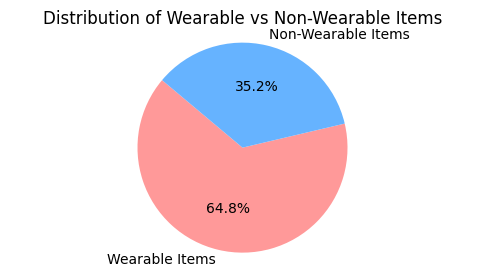

In [98]:
wearable_pipeline = [
    {"$match": {"slot": {"$ne": "Non-equippable"}}},  # Exclude items with "Non-Equippable"
    {"$count": "wearable_item_count"}]  # Get count of wearable items 

wearable_result = list(wotlk_items.aggregate(wearable_pipeline))
total_items_count = wotlk_items.count_documents({})
wearable_count = wearable_result[0]['wearable_item_count'] if wearable_result else 0
share_of_wearable_items = ((wearable_count / total_items_count) 
                           * 100) if total_items_count > 0 else 0

# piechart
labels = ['Wearable Items', 'Non-Wearable Items']
sizes = [wearable_count, total_items_count - wearable_count]
colors = ['#ff9999','#66b3ff']
plt.figure(figsize=(6, 3))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=False, startangle=140)
plt.axis('equal')  
plt.title('Distribution of Wearable vs Non-Wearable Items')
plt.show()

## 5.2 How many Staves are in the game?
The next pipeline looks for staves. These are weapons mainly used by casters. Even though they are not used for combat, they provide massive stat boosts. The pipeline matches the subclass 'Staff', which is the singular term for Staves and counts the amount.

$\fullwidthline$

In [54]:
pipeline = [{"$match": {
             "subclass": "Staff"}},
    {"$group": {
        "_id": None,  # We don't need to group by any specific field
        "staffCount": {"$sum": 1}}},  # Increment count for each staff item
    # Project to output the count without the _id
    {"$project": {
        "_id": 0,
        "staffCount": 1}}]

# Execute pipeline
staff_count_result = list(wotlk_items.aggregate(pipeline))

# Extract the count from the result and print it
staff_count = staff_count_result[0]['staffCount'] if staff_count_result else 0
print(f"Total number of Staff weapons: {staff_count}")

Total number of Staff weapons: 513


$\fullwidthline$

$\pagebreak$

## 5.3 Visualization of all weapons
Weapons are always of the highest interest in every WoW expansion. Not only do they have very good modifiers for each class, they also look nice if they are hard to obtain. This is why the next pipeline aggregates all items that are of class weapon and groups by each individual weapon subclass. The visualization is plotted with the matplotlib package.

$\fullwidthline$

In [100]:
pipeline = [
    {"$match": {"class": "Weapon"}},  # Filter for weapons
    {"$group": {"_id": "$subclass", "count": {"$sum": 1}}},  # Group by type and count.
    {"$sort": {"count": -1}}  # Sort by count desc
]
weapon_counts = list(wotlk_items.aggregate(pipeline))
subclasses = [item["_id"] for item in weapon_counts]
counts = [item["count"] for item in weapon_counts]

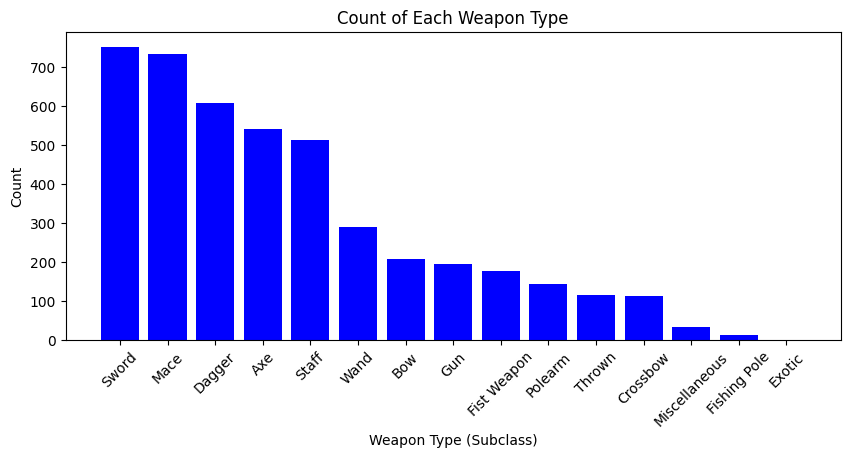

In [101]:
# matplotlib visualization
plt.figure(figsize=(10, 4))
plt.bar(subclasses, counts, color="blue")
plt.xlabel("Weapon Type (Subclass)")
plt.ylabel("Count")
plt.title("Count of Each Weapon Type")
plt.xticks(rotation=45)
plt.show()

The visualization shows that melee weapons such as swords, maces, daggers and axes are much more prevalent than caster weapons such as staves or wands. 


## 5.4 Caster armor pieces in each expansion
Since I played as a caster, I want to know which expansion is the most caster friendly one. In each expansion, major rants have been going on where, for example, players of melee classes were not happy with the amount of obtainable items from boss fights for their classes. I had the same feeling during the Wrath of the Lich King expansion, where I had the impression that a significant share of items were not made for casters. 

This is why in the following pipeline, I extracted all items, which have the source "boss drop", since items dropped by bosses of instanced zones had the best modifiers on them. Next, I look for items with subclass cloth. Casters are only allowed to wear cloth items. Then I look for the word 'spell' in the tooltip. Items that offer the best stat boost for casters have tooltips like 'increases spell power by 60' or  in earlier versions of the game 'increases damage done by spells and magic effects by 60'. I also need to filter for the maximum level in each expansion, to distinguish between the three versions of the game. The expansions maximum level by a playable character is 60 for the base game, 70 for the burning crusade and 80 for wrath of the lich king. I also included a quality check. With matching for only <span style="color: purple;">epic</span> or <span style="color: orange;">legendary</span> quality, I make sure that only the best of items appear in the output.

$\fullwidthline$

In [17]:
pipeline = [{"$match": {
            "source.category": "Boss Drop",  # Only boss drop items
            "subclass": "Cloth",             # Only cloth items
            # Spell Power (called "...spells and magic effects..." in base game and TBC
            "tooltip": {"$regex": "spell"},  
            "quality": {"$in": ["Epic", "Legendary"]}}},  # Only Epic or Legendary quality
    # Project only necessary fields
    {"$project": {"name": 1, "requiredLevel": 1, "tooltip": 1}},
    # Match only items for level 60, 70, or 80, to get only the best items
    {"$match": {"requiredLevel": {"$in": [60, 70, 80]}}},
    # Group by requiredLevel and count the items
    {"$group": {"_id": "$requiredLevel", "count": {"$sum": 1}}}]

# Run the aggregation pipeline
result = wotlk_items.aggregate(pipeline)

# initialise the grouped items count by required level
level_60_count = 0
level_70_count = 0
level_80_count = 0

for doc in result:
    if doc["_id"] == 60:
        level_60_count = doc["count"]
    elif doc["_id"] == 70:
        level_70_count = doc["count"]
    elif doc["_id"] == 80:
        level_80_count = doc["count"]

print(f"Available caster equipment at level 60: {level_60_count}")
print(f"Available caster equipment at level 70: {level_70_count}")
print(f"Available caster equipment at level 80: {level_80_count}")

Available caster equipment at level 60: 82
Available caster equipment at level 70: 95
Available caster equipment at level 80: 57


$\fullwidthline$

It is apparent that with each expansion, the amount of suitable caster items increases. This can be explained by the growing popularity of WoW during these expansions and the addition of more playable content with each expansion. For The burning crusade (level 70) and Wrath of the Lich King (level 80), Each dungeon or raid had additional difficulty levels added. Whereas in the base game (level 60), a raid existed only in one difficulty mode, in The burning crusade, each raid could be done in either normal or heroic mode, and in Wrath of the Lich King, each mode could be played with either 10 or 25 players, adding up to 4 different versions of the same raid. The data does not allow for a distinction between these variants. This is why in Wrath of the Lich King, the amount of items almost tripled.
 
This pipeline excludes the fact that many more <span style="color: purple;">epic</span> or <span style="color: orange;">legendary</span> cloth items are in the game, but they do not have the spell power modifier, which boosts a caster's damage the most. This also means that my assumption that Wrath of the Lich King had less caster items available than the other two installations of WoW is wrong.

$\pagebreak$


## 5.5 Bosses with most items

I already mentioned that raiding is of key interest at max character level. Raiding in WoW can take multiple hours per week and therefore, maximising the amount of items obtained during a raid is what every player aims for. This is why I created a pipeline that shows the top ten bosses which offer the most items. The pipeline also extracts the name of each boss from the source and the required level.

$\fullwidthline$

In [58]:
# top 10 bosses with most items
pipeline = [{"$match": {
            "source.category": "Boss Drop"}},
        # Group by both the boss name and requiredLevel, and count items
        # group by requiredLevel, because some bosses appear in multiple expansions
        {"$group": {
            "_id": {
                "bossName": "$source.name",
                "requiredLevel": "$requiredLevel"},
            "itemCount": {"$sum": 1}}},
        {"$sort": {"itemCount": -1}},
        {"$limit": 10}]

# Execute the aggregation pipeline
top_bosses = wotlk_items.aggregate(pipeline)

# extract values from top_bosses dictionary
df = pd.DataFrame([{
    "Boss Name": boss["_id"]["bossName"],
    "Item Count": boss["itemCount"]
} for boss in top_bosses])

print(df)

               Boss Name  Item Count
0              Anub'arak         133
1          Lord Jaraxxus          97
2                Icehowl          88
3          The Lich King          60
4                 Halion          56
5              Festergut          56
6  Valithria Dreamwalker          54
7         Prince Valanar          54
8         Lord Marrowgar          54
9      Lady Deathwhisper          54


$\pagebreak$

## 5.6 Items mapped to zone Naxxramas
My favourite raid of all time is Naxxramas, from the base game. Because this raid was only available for a very short amount of time and was extremely hard to complete, the developers re-opened this raid with an increased level requirement in the expansion Wrath of the Lich King. The difficulty was increased to match the newer content, but many iconic items were not re-introduced to the game. This included for example Atiesh, which is mentioned in the Introduction, or the iconic Corrupted Ashbringer.

This pipeline filters for the zone id that matches the entry for Naxxramas in the zones file. It then extracts the item and boss name and displays the ten first entries of the aggregation. The match for a required level of 60 is included to make sure that only the base-game version of Naxxramas is considered. 

$\fullwidthline$

In [102]:
# initialise variables to match zone id in wotlk_zones to wotlk_items source
zone_name = "Naxxramas"
zone = db['wotlk_zones'].find_one({"name": zone_name})

if zone:
    zone_id = zone["id"]
else:
    print(f"Zone '{zone_name}' not found.")
    zone_id = None

if zone_id:
    pipeline = [{"$match": {
                    "quality": {"$in": ["Epic", "Legendary"]},
                    "requiredLevel": 60,
                    "source.zone": zone_id,  # Filter by zone ID
                    "slot": {"$ne": "Non-equippable"}}},  # Ensure that item can be worn
        {"$project": {
                "Item": "$name",         # Rename field to "Item Name"
                "Boss": "$source.name",  # Get the boss name from source
                "_id": 0 }},             # Exclude the _id field     
            {"$limit": 10 }]             # Limit the output to 10 items
       

    # Execute the pipeline
    results = list(db['wotlk_items'].aggregate(pipeline))
    df = pd.DataFrame(results)
    print(df)

                Item                  Boss
0  Might of Menethil            Kel'Thuzad
1         Soulseeker            Kel'Thuzad
2    Brimstone Staff               Loatheb
3  Spire of Twilight              Thaddius
4          Kingsfall            Kel'Thuzad
5      Midnight Haze             Grobbulus
6     Maexxna's Fang               Maexxna
7    Widow's Remorse  Grand Widow Faerlina
8       Wraith Blade               Maexxna
9     The Castigator              Thaddius


## 5.7 Items with the highest intellect boost
There are primary and secondary stat boosts on all wearable items. primary stats are only useful for certain classes. A warrior, for example, can make no use of intellect or wisdom. The following primary stats exist:

- Strength
- Agility
- Armor
- Stamina
- Wisdom
- Intellect

Whereas Stamina increases a players health points, which is obviously useful for all classes, intellect, on the other hand, increases a player's mana points and the ability to hit critical with spells and magic effects. Therefore, in the next pipeline, I filter the tooltip for the intellect boost, which can look as follows.

'+45 Intellect'

There are also items, which belong to a set. Depending on how many set-pieces a player owns, more stat boosts are available. For example, if a player owns 5 pieces of a set, the tooltip of the set-benefit can look as follows:

'Set(5): +10 Intellect'

This tooltip is ignored by the next pipeline, since I am not interested in them. Next, the integer value of the main Intellect boost is extracted and the 10 items with the highest intellect boost over all are extracted.

$\pagebreak$

In [89]:
# pipeline to extract intellect boosts, extract the 
# integer value from string and display 10 best items
pipeline = [
    {'$match': {'tooltip': {
                '$elemMatch': {
                    # Match only intellect boosts via regex
                    # starting with +, any number and 'Intellect'
                    '$regex': r'^\+\d+\s*Intellect$',  
                    '$options': 'i'}}}}, # non case sensitive
    {'$project': {'id': 1, 'name': 1,
                  'intellect_boost': {'$arrayElemAt': [{'$filter': {
                            'input': '$tooltip',
                            'as': 'tooltip_item',
                            'cond': {'$regexMatch': {
                            'input': '$$tooltip_item',
                            # Ensure it matches only this format and ignores sets
                            'regex': r'^\+\d+\s*Intellect$',
                            # Get the first tooltip with intellect boost
                            'options': 'i'}}}},0]}}},
    {'$addFields':
         {'intellect_value':
              {'$convert':
                   {'input':
                        {'$arrayElemAt':
                             [{'$split': ['$intellect_boost',' ']},
                            # Take the first element, which is only the number
                            # convert this number to int to be able to sort
                            0]}, 'to': 'int' }}}},
    {'$sort': {'intellect_value': -1}},
    {'$limit': 10 }]

# Execution of the pipeline
top_intellect_items = list(wotlk_items.aggregate(pipeline))
df = pd.DataFrame(top_intellect_items)
df = df[['name', 'intellect_boost']]

# Print output
print("Top 10 Items with Highest Intellect Boost:")
print(53*'*')
print(df)

Top 10 Items with Highest Intellect Boost:
*****************************************************
                                 name intellect_boost
0                            Clemency  +153 Intellect
1                          Sufferance  +153 Intellect
2          Sanctified Dark Coven Hood  +139 Intellect
3    Sanctified Frost Witch's Hauberk  +139 Intellect
4        Corp'rethar Ceremonial Crown  +139 Intellect
5      Sanctified Dark Coven Leggings  +139 Intellect
6          Sanctified Dark Coven Robe  +139 Intellect
7  Sanctified Frost Witch's Legguards  +139 Intellect
8       Sanctified Frost Witch's Helm  +139 Intellect
9       Sanctified Frost Witch's Kilt  +139 Intellect


The items Clemency and Sufferance are in fact the same item. They just change appearances depending on the faction a player belongs to. Clemency is the <span style="color: blue;">Alliance</span> version, whereas Sufferance is the <span style="color: red;">Horde</span> variant. The ingame tooltip of Sufferance looks as follows and confirms the intellect boost.

![Sufferance](./images/Sufferance.png)

These items are very sought after by all caster classes, but they are also extremely hard to get. The items are only obtainable from a chest after beating all bosses in a very hard raid in Wrath of the Lich King. The chest howewer, only appears if nobody died during the whole raid. Having players die in boss-fights is common and can only be avoided when each fight is planned out meticulously and everybody knows the game so well that they could play blindfolded. 

$\pagebreak$

## 5.8 Legendary items and their sources

In the next pipeline, I am looking for legendary items. It is always a jaw-dropper if a player with a legendary item is passing by. This is why all legendary items are being displayed, not just caster focused legendaries. This is manily done by filtering for quality.

I also need to filter for slot, since I only want to display items that can be worn. Many quest items are also of legendary quality, such as fragments of some legendary weapons, which a player needs to collect in order to obtain the actual legendary weapon in the end. An example of this is Shadowmourne. A legendary axe which is assembled by looting 40 fragments from bosses, which have a very low drop-chance. Lastly, I ignore all items from the zone Tempest Keep. This is a unique zone which offers special legendary weapons to each player to fight the boss Kael'Thas Sunstrider. These weapons diasppear 15 minutes after obtaining them and are only intended for this fight alone.

$\fullwidthline$

In [105]:
pipeline = [
    {'$match': {
            'quality': 'Legendary',  # Filter for legendary items
            'slot': {'$ne': 'Non-equippable'}, # Exclude items which are not wearable
            'source.zone': {'$ne': 3845}       # exclude Tempest Keep zone id
        }},
    {'$lookup': {
        'from': 'wotlk_zones',  # Join with the zones collection
        'localField': 'source.zone',  # Field in items to match (for boss drop sources only)
        'foreignField': 'id',  # Field in zones to match
        'as': 'zone_info'}},  # Output array with matching zone info
    {'$unwind': {
            'path': '$zone_info',
            # Allow items without a zone, such as items from quests 
            'preserveNullAndEmptyArrays': True}},   
    {'$project': {
        'name': 1,
            # Determine if the source is a quest or a boss drop
            'source': {
                '$cond': {
                    'if': {'$eq': ['$source.category', 'Quest']},
                    'then': 'Quest',
                    'else': '$source.category'}},
            'zone_name': '$zone_info.name'  # Extract the zone name from the joined data
        }}]  # Extract the zone name from the joined data
        
        
# Execute the aggregation pipeline
legendary_items = list(wotlk_items.aggregate(pipeline))
df = pd.DataFrame(legendary_items)
df = df[['name', 'source', 'zone_name']]

# Print the DataFrame
print("Legendary Items, Source, and Zone:")
print(76*'*')
print(df)

Legendary Items, Source, and Zone:
****************************************************************************
                                            name     source        zone_name
0                     Sulfuras, Hand of Ragnaros        NaN              NaN
1   Thunderfury, Blessed Blade of the Windseeker      Quest              NaN
2             Atiesh, Greatstaff of the Guardian      Quest              NaN
3             Atiesh, Greatstaff of the Guardian      Quest              NaN
4             Atiesh, Greatstaff of the Guardian      Quest              NaN
5             Atiesh, Greatstaff of the Guardian      Quest              NaN
6                     Andonisus, Reaper of Souls        NaN              NaN
7                          Warglaive of Azzinoth  Boss Drop     Black Temple
8                          Warglaive of Azzinoth  Boss Drop     Black Temple
9                     Thori'dal, the Stars' Fury  Boss Drop  Sunwell Plateau
10             Val'anyr, Hammer of Ancien

$\fullwidthline$


Now why do items such as Atiesh and Warglaive of Azzinoth appear multiple times? Atiesh is obtained through a quest, which can be done by multiple classes such as Druids, Priests, Warlocks and Mages. The quest is different for each class, this is why the weapon appears 4 times. The Warglaive of Azzinoth does exist twice. Those are one-handed swords and a version for the left and the right hand exist which have the same name. When a player with both warglaives passes by, we take a screenshot of it, this is why I must include an image of them.

![Glaive](./images/glaives.png)

As already mentioned, items which are obtainable through a quest have no zone in the source information. Items which have no source at all are created by a special action. For example, to get Sulfuras, Hand of Ragnaros, a player needs to craft a Hammer of epic quality and combine it with a miscellaneous item obtained from the Boss Ragnaros to create the legendary hammer Sulfuras.

$\pagebreak$

## 5.9 Highest selling items
Money is always of interest in WoW. This is why in this pipeline, I want to find the top 10 selling items in WoW. This is done by looking up the selling price. The datatype is integer. The currency in WoW is called 'Gold'. But gold is only one part. 100 copper equals 1 silver. 100 silver equals 1 gold. The sell price in this data set is the value in copper. This pipeline also filters for items that are obtainable from bosses. 

$\fullwidthline$

In [34]:
pipeline = [
    # Filter to include only items with source category "Boss Drop" and sellPrice > 0
    {"$match": {"sellPrice": {"$gt": 0}, "source.category": "Boss Drop"}},
    {"$sort": {"sellPrice": -1}},
    {"$limit": 10},
    # Project fields with formatted gold, silver, copper breakdown
    {"$project": {
            "_id": 0,  # Exclude the _id field
            "name": 1,
            "sellPrice": 1,
            "gold": {"$floor": {"$divide": ["$sellPrice", 10000]}},
            "silver": {"$floor": {"$mod": [{"$divide": ["$sellPrice", 100]}, 100]}},
            "copper": {"$mod": ["$sellPrice", 100]},}},
    # Create a formatted sellPrice string
    {"$addFields": {
        "formattedSellPrice": {
            "$concat": [
                {"$toString": "$gold"}, " gold, ",
                {"$toString": "$silver"}, " silver, ",
                {"$toString": "$copper"}, " copper"]}}},
    # Final projection to include only relevant fields in the output
    {"$project": {"name": 1, "formattedSellPrice": 1}}]

# Execute the pipeline
top_items = list(wotlk_items.aggregate(pipeline))

# Convert to a pandas DataFrame for better display
df = pd.DataFrame(top_items)
print(df)


                                        name             formattedSellPrice
0                Bryntroll, the Bone Arbiter  34 gold, 83 silver, 29 copper
1                                   Nibelung  34 gold, 72 silver, 26 copper
2   Oathbinder, Charge of the Ranger-General   34 gold, 36 silver, 7 copper
3                                Dying Light  34 gold, 33 silver, 81 copper
4   Oathbinder, Charge of the Ranger-General  33 gold, 90 silver, 76 copper
5            Archus, Greatstaff of Antonidas  33 gold, 40 silver, 42 copper
6                                   Nibelung  33 gold, 38 silver, 81 copper
7                        Warmace of Menethil  33 gold, 38 silver, 52 copper
8                                 Cryptmaker  33 gold, 38 silver, 18 copper
9  Glorenzelg, High-Blade of the Silver Hand  33 gold, 27 silver, 75 copper


$\fullwidthline$

We can see that certain items appear twice. This is due to the fact that these items are from Wrath of the Lich King raid bosses. As already mentioned, in this expansion pack, a raid appears in four difficulty levels. The obtainable items have the same name, but different modifiers depending on the raid difficulty. Unfortunately, there is no information about the difficulty level in this data. The selling price suggests that the higher selling item is obtained from the higher difficulty level raid. We can again check a screenshot of an ingame tooltip to verify the sell price conversion.

![Bryntroll](./images/bryntroll.png)

$\pagebreak$

## 5.10 A tribute to dungeons - with index creation
WoW does not only have raids as high difficulty, high reward zones. There are less difficult instanced zones for five player groups, which are called Dungeons. These also offer higher quality items which offer a good starting point before a player starts with raids. Unlike raids, dungeons can be entered before reaching the highest level. Some Dungeons can be entered already at level 16. This pipeline aggregates the amount of items that can be obtained from each zone that is of zone category 'Dungeon'. To show that they are not only for max level players, I also extract the minimal required level a player needs to wear items from these Dungeons. This information is extracted from the 'requiredLevel' field in the items data. Since this aggregation pipeline turned out to be quite extensive and the data set overall is moderate in size, indices were created to speed up performance.

$\fullwidthline$

In [16]:
# index creation. first on source category, zone slot and level requirement
wotlk_items.create_index([
    ("source.category", pymongo.ASCENDING),
    ("source.zone", pymongo.ASCENDING),
    ("slot", pymongo.ASCENDING),
    ("requiredLevel", pymongo.ASCENDING)])
# Index on wotlk_zones collection to improve join performance in lookup stage
wotlk_zones.create_index([
    ("id", pymongo.ASCENDING),        
    ("category", pymongo.ASCENDING)]);                                 

In [15]:
pipeline = [{"$match": {
            "source.category": "Boss Drop",
            "source.zone": {"$exists": True},
            "slot": {"$ne": "Non-equippable"},
            "requiredLevel": {"$gt": 0}}},  # Exclude items without level requirements
    # Lookup to join zones collection to get zone details
    {"$lookup": {
            "from": "wotlk_zones",
            "localField": "source.zone",
            "foreignField": "id",
            "as": "zone_info"}},
    {"$unwind": "$zone_info"},
    {"$match": {"zone_info.category": "Dungeon"}},
    {"$group": {
            "_id": "$zone_info.name",
            "itemCount": {"$sum": 1},
            "minRequiredLevel": {"$min": "$requiredLevel"}}},
    {"$sort": {"itemCount": -1}},
    {"$limit": 10},
    {"$project": {
            "_id": 0,
            "zoneName": "$_id",
            "itemCount": 1,
            "minRequiredLevel": 1}}]

# Execute pipeline
top_dungeon_zones = list(wotlk_items.aggregate(pipeline))
df = pd.DataFrame(top_dungeon_zones)
print(df)

   itemCount  minRequiredLevel                    zoneName
0        140                51             Blackrock Spire
1        121                47            Blackrock Depths
2        111                50                   Dire Maul
3        108                52                  Stratholme
4         71                54                 Scholomance
5         54                63                The Underbog
6         50                70          Magisters' Terrace
7         48                64                  Mana-Tombs
8         47                76          Halls of Lightning
9         44                70  Ahn'kahet: The Old Kingdom


$\fullwidthline$

This shows that Dungeons from the base game offered many more items than later versions and were in fact much larger. The five dungeons that offer the most items can be entered at levels below 60, whereas the Dungeons on ranks 5 to 10 can be entered only after reaching level 60. As a player myself, I can confirm that a 5-player Dungeon like Blackrock Depths was much more time-consuming than a basic 25-player raid of the Wrath of the Lich King expansion. 

$\pagebreak$

## 5.11 Armor sets
We have already seen that some wearable items belong to a set. In this pipeline, I want to see how many armor sets there are. All armor pieces that belong to a set have a corresponding tooltip that indicates this, such as 'setname (0/5)' indicating that 5 pieces belong to this armor set. 

$\fullwidthline$

In [110]:
pipeline = [{"$match": {
            "tooltip": {
                "$regex": r".*\(\d+\/\d+\).*"}}}, # regex '(0/5)' can be any number
    # Project to include  matching tooltips
    {"$project": {
            "set_info": {
                "$filter": {
                    "input": "$tooltip",
                    "as": "tooltip_item",
                    "cond": {
                        "$regexMatch": {
                            "input": "$$tooltip_item",
                            # Find strings indicating set information
                            "regex": r".*\(\d+\/\d+\)"}}}}}},
    {"$unwind": "$set_info"}, # Unwind the set_info to separate entries
    {"$group": {"_id": "$set_info",}},  # Group to get unique sets
    ]
# Execute the pipeline
armor_set_results = list(wotlk_items.aggregate(pipeline))

# Print the results in the desired format
print('First 10 armor sets:')
print(40 * '*')
for i, armor_set in enumerate(armor_set_results):
    if i >= 10:  # Stop after 10 entries
        break
    print(armor_set['_id'][:-5])  # Ignore the last 5 characters
print(40 * '*')
print('Total amount of armor sets: ' + str(len(armor_set_results)))

First 10 armor sets:
****************************************
Furious Gladiator's Wildhide 
Seer's Linked Battlegear 
Merciless Gladiator's Vestments 
Valorous Earthshatter Battlegear 
Lightforge Armor 
Shiny Shard of the Gods 
Gladiator's Wartide 
Emblems of Veiled Shadows 
Merciless Gladiator's Wildhide 
Heroes' Dreamwalker Battlegear 
****************************************
Total amount of armor sets: 704


## 5.12 Extraction of a recipe
Since I extracted all the information of the key 'CreatedBy' and altered it to 'recipe' I want to work with this information as well. The last aggregation pipeline makes the recipe more human-readable. Instead of item-id's, the item name and the corresponding amount is extracted and printed. For this, a specific item is matched. I chose an item I did craft myself back in the days, which was the epic Sulfuron Hammer. The one that is needed to create the legendary Sulfuras, Hand of Ragnaros. 

$\fullwidthline$

In [45]:
pipeline = [
    # Match the specific item Sulfuron Hammer with id 17193
    {"$match": {"id": 17193}},
    {"$unwind": "$recipe"}, # Unwind `recipe` array to access recipe details
    {"$unwind": "$recipe.reagents"}, # Unwind the `reagents` array to access each reagent
    {"$lookup": { # Self-lookup to join with the same collection
        "from": "wotlk_items",
        "localField": "recipe.reagents.itemId",
        "foreignField": "id",
        "as": "reagent_info"}},
    {"$unwind": "$reagent_info"}, # Unwind `reagent_info` to access each reagent item
    {"$project": {"_id": 0, "recipe": { # Project to show each reagent's name and amount
            "name": "$reagent_info.name",
            "amount": "$recipe.reagents.amount"}}},
    {"$group": {"_id": None,
        "recipe": {"$push": {"name": "$recipe.name", "amount": "$recipe.amount"}}}},
    {"$project": {"_id": 0, "recipe": "$recipe"}}]

result = list(wotlk_items.aggregate(pipeline)) # execute
print('Recipe for Sulfuron Hammer:') # print nicely formatted
print(30*'-')
if result and "recipe" in result[0]:
    max_name_length = max(len(entry["name"]) for entry in result[0]["recipe"])
    print("Reagent".ljust(max_name_length) + "  Amount")
    print("-" * (max_name_length + 9))
    for entry in result[0]["recipe"]:
        print(f"{entry['name'].ljust(max_name_length)}  {entry['amount']}x")
else:
    print("No recipe information found for this item.")

Recipe for Sulfuron Hammer:
------------------------------
Reagent                Amount
------------------------------
Sulfuron Ingot         8x
Dark Iron Bar          20x
Arcanite Bar           50x
Essence of Fire        25x
Blood of the Mountain  10x
Lava Core              10x
Fiery Core             10x


$\fullwidthline$

## 5.13 Going further - Most used items in Crafting
Wouldn't it be nice to check how many reagents are needed if a player were to craft every single craftable item in the game? In this last pipeline, I match for all craftable items, unwind the recipe and reagents, group by each reagent id, look up the item id in the same collection and sum them up. Since this list would be extensive, the output is again limited to the top ten most used reagents.

$\fullwidthline$

In [51]:
pipeline = [
    # Match only items with a recipe (craftable items), unwind same as before
    {"$match": {"recipe": {"$exists": True, "$ne": []}}},
    {"$unwind": "$recipe"},
    {"$unwind": "$recipe.reagents"},
    {"$group": { # group by each reagent id
        "_id": "$recipe.reagents.itemId",
        "totalAmount": {"$sum": "$recipe.reagents.amount"}}},
    {"$sort": {"totalAmount": -1}}, # Sort by total amount in descending order
    {"$limit": 10},
    {"$lookup": { # Lookup to retrieve the items for top reagents
            "from": "wotlk_items",
            "localField": "_id",
            "foreignField": "id",
            "as": "reagent_info"}},
    {"$unwind": "$reagent_info"}, # Unwind reagent_info to access name details
    {"$project": {
        "_id": 0,
        "name": "$reagent_info.name",
        "totalAmount": 1}}]

top_reagents = list(wotlk_items.aggregate(pipeline))
max_name_length = max(len(entry["name"]) for entry in top_reagents)
print('Top 10 most needed items to craft every item once:')
print("-" * (max_name_length + 15))
print("Reagent".ljust(max_name_length) + "  Total Amount")
print("-" * (max_name_length + 15))

for entry in top_reagents:
    print(f"{entry['name'].ljust(max_name_length)}  {entry['totalAmount']}x")


Top 10 most needed items to craft every item once:
-------------------------------------
Reagent                 Total Amount
-------------------------------------
Thorium Bar             1229x
Rugged Leather          1135x
Saronite Bar            890x
Heavy Borean Leather    880x
Heavy Knothide Leather  852x
Mithril Bar             657x
Thick Leather           575x
Primal Air              501x
Primal Fire             489x
Primal Life             461x


# 6 Conclusion
The ELT process of this project did run smoothly without any issues. Some minor transformations were needed to enhance data quality, unfortunately, not all issues were resolved. For the scope of this report, the performed transformations were sufficient. More on the source of the items could have been done, but not without major tweaks on thousands of individual items. 

The analysis of the data was performed with 13 pymongo aggregation pipelines. The data would allow for much more. Further distinction between the items of the base game and the two expansions could be made, more in-depth analysis of craftable items and their recipes or a thorough price analysis could offer many more valuable insights. Going even deeper, it could be analysed which in-game zone offers the highest monetary reward according to the obtainable items in the zone.

To conclude, this project provided many insights and learnings and I can imagine myself analysing this data further to increase the newly gained knowledge about pymongo aggregation pipelines and NoSQL in general.


# 7 Lessons Learned

This was a fun and educational project. My main technical learnings are the deep-dive into the aggregation pipelines. After getting used to the top-level structure of 'match', 'unwind', 'group', 'sort', 'project' and 'limit', the possibilities are near endless and with each pipeline done, there were more things I wanted to explore. I had tremendous difficulties learning the syntax during the Datacamp course, but with this project, I gut used to it and only had to look up the special syntax in the end, like regular expressions and conditions.

Furthermore, this project again showed how important data quality is. I faced many issues because the structure of the data was not identical for all documents. I could eliminate some of these issues in the extract and transform phase, but unfortunately not all of them. Missing item sources was the biggest issue of all, because this did not allow to create nice outputs for all the pipelines. Since I was very interested in the aggregation and the data itself, I still left these aggregation pipelines in the report, such as the one where the source of legendary items is displayed.

Overall, this project allowed me to get used to NoSQL and MongoDB in the first place, which I have never used before. I like it better than SQL and can imagine myself doing other projects with NoSQL in the future.
